## Image Preparation For Convolutional Neural Networks

    We'll be using Kaggle's Dogs vs. Cats dataset

In [ ]:
# download dataset from: https://www.kaggle.com/c/dogs-vs-cats/data
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.competition_download_file('dogs-vs-cats', 'train.zip')
# then I moved the file to the folder 'dogs-cats-data/'

In [3]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# Organize data into train, valid, test dirs
os.chdir('/home/samanthalof/git/Learning/keras_tf_deeplizard/dogs-cats-data')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')
    
for i in random.sample(glob.glob('outros/cat*'), 500):
    shutil.move(i, 'train/cat')      
for i in random.sample(glob.glob('outros/dog*'), 500):
    shutil.move(i, 'train/dog')
for i in random.sample(glob.glob('outros/cat*'), 100):
    shutil.move(i, 'valid/cat')        
for i in random.sample(glob.glob('outros/dog*'), 100):
    shutil.move(i, 'valid/dog')
for i in random.sample(glob.glob('outros/cat*'), 50):
    shutil.move(i, 'test/cat')      
for i in random.sample(glob.glob('outros/dog*'), 50):
    shutil.move(i, 'test/dog')

os.chdir('../')

In [4]:
train_path = 'dogs-cats-data/train'
valid_path = 'dogs-cats-data/valid'
test_path = 'dogs-cats-data/test'

In [5]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [19]:
print(type(train_batches), type(valid_batches), type(test_batches))
len(train_batches),len(valid_batches), len(train_batches)
# looks like the batches have 10% of the dataset size, this is because the argument "batch_size=10"

<class 'keras.preprocessing.image.DirectoryIterator'> <class 'keras.preprocessing.image.DirectoryIterator'> <class 'keras.preprocessing.image.DirectoryIterator'>


(100, 20, 100)

In [6]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [10]:
imgs, labels = next(train_batches)

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

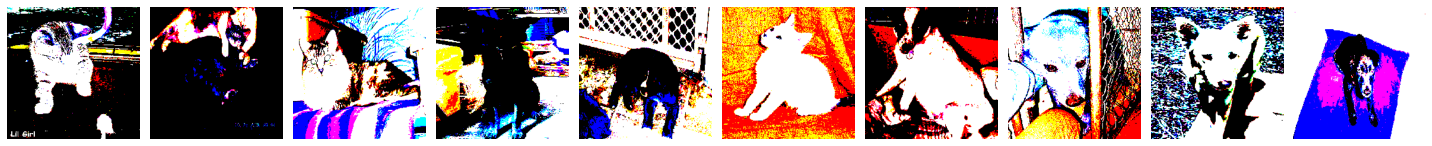

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [12]:
plotImages(imgs)
print(labels)

### Code Update For CNN Training With TensorFlow's Keras API

The parameter 'steps_per_epoch' is the number of steps (batches of samples) to yield from the training set before declaring one epoch finished and starting the next epoch.

The parameter called 'validation_steps' acts in the exact same way as steps_per_epoch, except for on our validation set.

In [20]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

2022-04-11 23:13:03.546366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ohpc/pub/mpi/openmpi3-gnu7/3.1.0/lib:/opt/ohpc/pub/compiler/gcc/7.3.0/lib64:/usr/local/ncarg/lib:/opt/intel/compilers_and_libraries_2020.1.217/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2020.1.217/linux/mpi/intel64/libfabric/lib:/opt/intel/compilers_and_libraries_2020.1.217/linux/mpi/intel64/lib/release:/opt/intel/compilers_and_libraries_2020.1.217/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2020.1.217/linux/ipp/lib/intel64:/opt/intel/compilers_and_libraries_2020.1.217/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2020.1.217/linux/tbb/lib/intel64/gcc4.8:/opt/intel/compilers_and_libraries_2020.1.217/linux/daal/lib/intel64_lin:/opt/intel/debugger_2020/python/intel64/lib:/opt/intel/debugger_2020/libi

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 20s - loss: 16.3698 - accuracy: 0.5820 - val_loss: 7.2117 - val_accuracy: 0.5700 - 20s/epoch - 204ms/step
Epoch 2/10
100/100 - 18s - loss: 2.7901 - accuracy: 0.7400 - val_loss: 4.9735 - val_accuracy: 0.5450 - 18s/epoch - 177ms/step
Epoch 3/10
100/100 - 18s - loss: 0.9967 - accuracy: 0.8340 - val_loss: 4.1102 - val_accuracy: 0.5850 - 18s/epoch - 179ms/step
Epoch 4/10
100/100 - 18s - loss: 0.3522 - accuracy: 0.9280 - val_loss: 3.7414 - val_accuracy: 0.5600 - 18s/epoch - 182ms/step
Epoch 5/10
100/100 - 18s - loss: 0.0678 - accuracy: 0.9770 - val_loss: 4.2392 - val_accuracy: 0.5500 - 18s/epoch - 184ms/step
Epoch 6/10
100/100 - 18s - loss: 0.0418 - accuracy: 0.9870 - val_loss: 3.9005 - val_accuracy: 0.5550 - 18s/epoch - 181ms/step
Epoch 7/10
100/100 - 18s - loss: 0.0050 - accuracy: 0.9990 - val_loss: 3.5209 - val_accuracy: 0.5750 - 18s/epoch - 180ms/step
Epoch 8/10
100/100 - 18s - loss: 8.2703e-04 - accuracy: 1.0000 - val_loss: 3.3796 - val_accuracy: 0.5800 - 18s/epoch 

## Predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

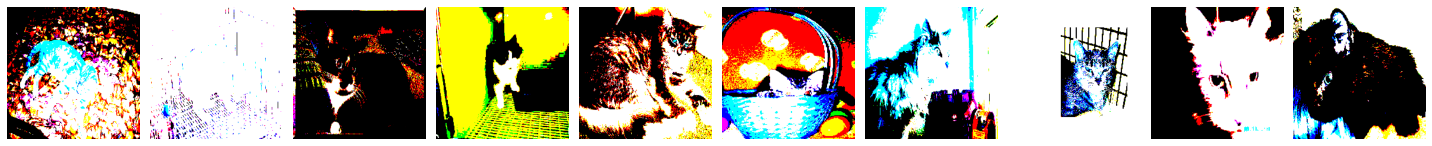

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [25]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [27]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [26]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [30]:
np.round(predictions)

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [31]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [33]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[33 17]
 [10 40]]


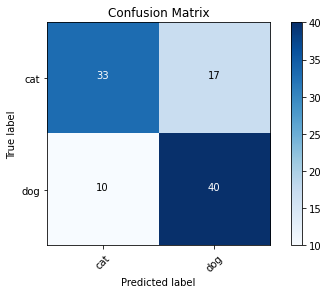

In [34]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Data Augmentation

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [36]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [37]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [44]:
chosen_image = random.choice(os.listdir('dogs-cats-data/train/dog'))

In [52]:
image_path = 'dogs-cats-data/train/dog/' + chosen_image

In [53]:
assert os.path.isfile(image_path)

In [54]:
image_path

'dogs-cats-data/train/dog/dog.3241.jpg'

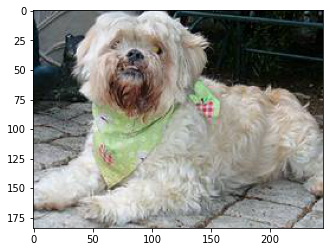

In [55]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [56]:
aug_iter = gen.flow(image)

In [57]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

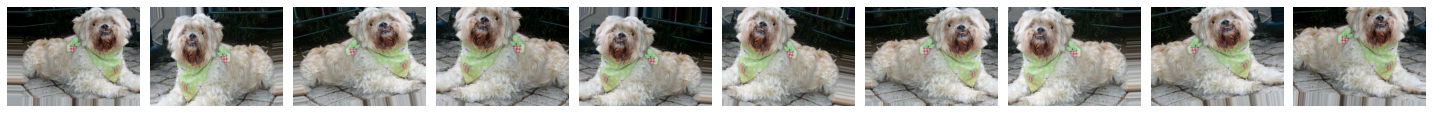

In [58]:
plotImages(aug_images)

In [61]:
aug_iter = gen.flow(image, save_to_dir='dogs-cats-data/train/dog', save_prefix='aug-image-', save_format='jpeg')

## Build A Fine-Tuned VGG16 model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

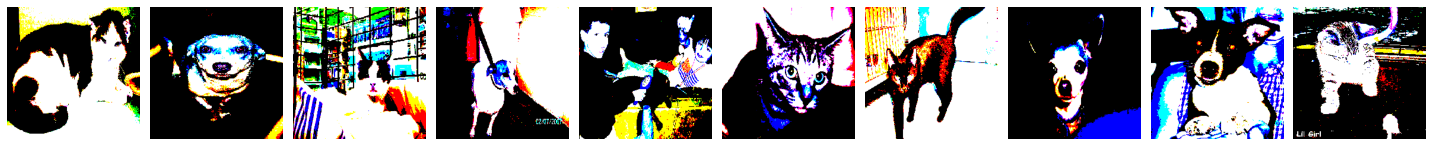

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [63]:
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

367042560/553467096 [==================>...........] - ETA: 30s

In [ ]:
vgg16_model.summary()